In [92]:
from time import sleep
import math
import random

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import matplotlib as mpl

from pong.pong import games_generator
from pong.renderer import Renderer

from matplotlib import cm

tf.enable_eager_execution()

In [2]:
get_game = games_generator(40, 40, 256)

In [3]:
_, (frame, _) = next(get_game)

(40, 40)

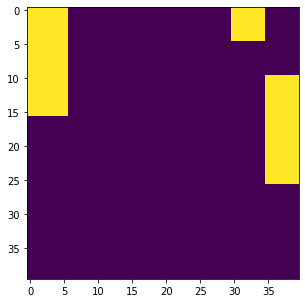

In [4]:
plt.figure(figsize=(5, 5))
plt.imshow(frame[120])
frame[120].shape

In [5]:
directions = []
controls = []
frames = []
done = []

for _ in tqdm(range(4000)):
    (d, c), (f, go) = next(get_game)
    directions.append(d)
    controls.append(c)
    frames.append(f)
    done.append(go)

directions = np.array(directions)
controls = np.array(controls)
frames = np.array(frames)
done = np.array(done)

directions.shape, controls.shape, frames.shape, done.shape

((4000,), (4000, 256, 2), (4000, 256, 40, 40), (4000, 256))

In [6]:
only_frames = frames.reshape((-1, 40, 40))
only_frames.shape

(1024000, 40, 40)

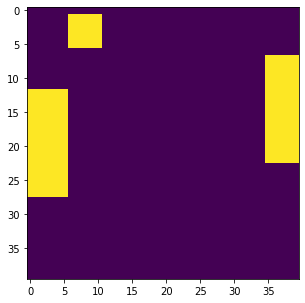

In [7]:
plt.figure(figsize=(5, 5))
plt.imshow(only_frames[98548])

In [8]:
i = tf.keras.layers.Input((40, 40), name='input')
e = i
e = tf.keras.layers.Reshape((40, 40, 1))(e)
e = tf.keras.layers.Conv2D(32, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Conv2D(64, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Conv2D(128, (4, 4), activation='relu', strides=2)(e)
e = tf.keras.layers.Reshape((3 * 3 * 128,), name='flatten')(e)
e = tf.keras.layers.Dense(32)(e)

d = e
d = tf.keras.layers.Dense(1024)(d)
d = tf.keras.layers.Reshape((1, 1, 1024))(d)
d = tf.keras.layers.Conv2DTranspose(128, (4, 4), activation='relu', strides=2)(d)
d = tf.keras.layers.Conv2DTranspose(64, (5, 5), activation='relu', strides=1)(d)
d = tf.keras.layers.Conv2DTranspose(32, (5, 5), activation='relu', strides=2)(d)
d = tf.keras.layers.Conv2DTranspose(1, (4, 4), activation='relu', strides=2)(d)
d = tf.keras.layers.Reshape((40, 40), name='frame')(d)

net = tf.keras.Model(i, d)

net.compile(
    loss='mse',
    optimizer='adam',
    metrics=['mse', 'accuracy']
)

In [9]:
encoder = tf.keras.Model(i, e)

In [10]:
decode_input = tf.keras.layers.Input((32,))
out = decode_input
for l in net.layers[7:]:
    out = l(out)
    
decoder = tf.keras.Model(decode_input, out)

In [11]:
net.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 40, 40)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 40, 40, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 19, 32)        544       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 64)          32832     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         131200    
_________________________________________________________________
flatten (Reshape)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                36896 

In [12]:
net.fit(
    x=only_frames,
    y=only_frames,
    batch_size=128
)

1024000/1024000 [==============================] - 77s 75us/sample - loss: 0.0022 - mean_squared_error: 0.0022 - acc: 0.4461


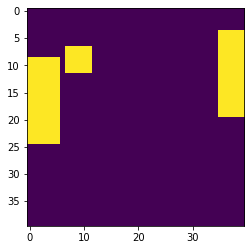

In [13]:
plt.imshow(only_frames[9000])

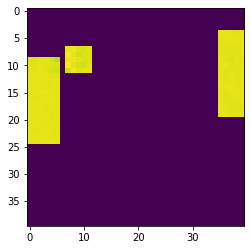

In [14]:
pred_f = net.predict(only_frames[9000].reshape(1, 40, 40)).reshape(40, 40)
plt.imshow(pred_f)

In [15]:
encoded_frames = []
for f in tqdm(frames):
    encoded_frames.append(encoder.predict(f))
        
encoded_frames = np.array(encoded_frames)
encoded_frames.shape

(4000, 256, 32)

In [16]:
class Memory:
    def __init__(self, stateful=False):
        bs = 1 if stateful else None

        init_dir = tf.keras.Input((1,), batch_size=bs)
        user_input = tf.keras.Input((None, 2), batch_size=bs)

        self.dir_hidden = tf.keras.layers.Dense(256)
        self.dir_cell_state = tf.keras.layers.Dense(256)
        self.lstm_input = tf.keras.layers.Dense(32)

        self.lstm = tf.keras.layers.GRU(
            256,
            return_sequences=True,
            stateful=stateful,
            name='lstm'
        )

        self.done_logits = tf.keras.layers.Dense(1)
        self.frame_logits1 = tf.keras.layers.Dense(128)
        self.frame_logits2 = tf.keras.layers.Dense(32)
        
        dh = self.dir_hidden(init_dir)
        dcs = self.dir_cell_state(init_dir)
        li = self.lstm_input(user_input)
        l = self.lstm(li, initial_state=[dh])
        dl = self.done_logits(l)
        fl = self.frame_logits2(self.frame_logits1(l))

        self.net = tf.keras.Model([init_dir, user_input], [fl, dl])
        self.net.compile(
            loss='mse',
            optimizer='adam',
            metrics=['mse']
        )

    def init(self, direction):
        self.direction = direction
        self.first_time = True

    def step(self, user_input):
        user_input = np.array([[user_input]])
        user_input = tf.convert_to_tensor(user_input, dtype=tf.float32)

        direction = np.array([[self.direction]])
        direction = tf.convert_to_tensor(direction, dtype=tf.float32)

        li = self.lstm_input(user_input)

        if self.first_time:
            self.first_time = False
            dh = self.dir_hidden(direction)
            dcs = self.dir_cell_state(direction)
            l = self.lstm(li, initial_state=[dh])
        else:
            l = self.lstm(li)

        dl = self.done_logits(l)
        fl = self.frame_logits2(self.frame_logits1(l))

        return fl[0].numpy(), dl[0].numpy()
    
    def copy_in_stateful_model(self):
        stateful = Memory(stateful=True)
        for nb, layer in enumerate(self.net.layers):
            stateful.net.layers[nb].set_weights(layer.get_weights())
        return stateful

In [17]:
memory = Memory()
memory.net.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, None, 2)]    0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, None, 32)     96          input_3[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 256)          512         input_2[0][0]                    
____________________________________________________________________________________________

In [155]:
memory.net.fit(
    x=[directions.reshape(-1, 1), controls[:, 1:]],
    y=[encoded_frames[:, :-1], np.expand_dims(done[:, :-1], -1)],
    batch_size=128,
    epochs=25,
)

Epoch 1/25
4000/4000 [==============================] - 31s 8ms/sample - loss: 0.3276 - dense_7_loss: 0.2832 - dense_5_loss: 0.0441 - dense_7_mean_squared_error: 0.2834 - dense_5_mean_squared_error: 0.0442
Epoch 2/25
4000/4000 [==============================] - 30s 8ms/sample - loss: 0.3231 - dense_7_loss: 0.2792 - dense_5_loss: 0.0445 - dense_7_mean_squared_error: 0.2790 - dense_5_mean_squared_error: 0.0442
Epoch 3/25
4000/4000 [==============================] - 30s 8ms/sample - loss: 0.3234 - dense_7_loss: 0.2796 - dense_5_loss: 0.0434 - dense_7_mean_squared_error: 0.2801 - dense_5_mean_squared_error: 0.0433
Epoch 4/25
4000/4000 [==============================] - 31s 8ms/sample - loss: 0.3137 - dense_7_loss: 0.2717 - dense_5_loss: 0.0420 - dense_7_mean_squared_error: 0.2717 - dense_5_mean_squared_error: 0.0420
Epoch 5/25
4000/4000 [==============================] - 30s 8ms/sample - loss: 0.3056 - dense_7_loss: 0.2641 - dense_5_loss: 0.0412 - dense_7_mean_squared_error: 0.2645 - dense

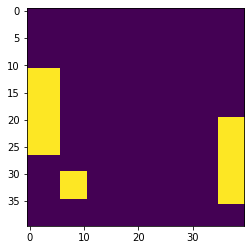

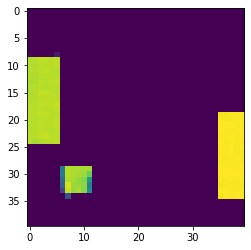

In [156]:
idx = 254
game_id = 100
plt.imshow(frames[game_id][idx])
plt.show()

pred_frames, pred_done = memory.net.predict([
    directions.reshape(-1, 1)[game_id:game_id+1],
    controls[:, 1:][game_id:game_id+1],
    encoded_frames[:, 1:][game_id:game_id+1]
])

pred_image = decoder(pred_frames[0][idx].reshape(1, -1))[0]
plt.imshow(pred_image)
plt.show()

In [160]:
def render_training_game():
    for game_id in range(len(encoded_frames)):
        latent_frames, _ = memory.net.predict([
            directions.reshape(-1, 1)[game_id:game_id+1],
            controls[:, 1:][game_id:game_id+1],
            encoded_frames[:, 1:][game_id:game_id+1]
        ])
        pred_frames = decoder(latent_frames[0])
        split_screens = np.concatenate(
            (frames[game_id,1:], pred_frames), axis=1
        )

        n = mpl.colors.Normalize(vmin=0, vmax=1)
        split_screens = n(split_screens)
        split_screens = cm.bwr(1 - split_screens)

        Renderer.init_window(500, 1000)    
        for frame in split_screens:
            if not Renderer.can_render(): return
            Renderer.show_frame(frame)

render_training_game()

In [158]:
def render_actual_game():
    stateful = memory.copy_in_stateful_model()
    
    while True:
        stateful.init(random.uniform(0, 2 * math.pi))

        def step(user_input):
            pref_frame, done = stateful.step(user_input)
            return decoder.predict(pref_frame)[0], done

        FPS = 60
        Renderer.init_window(500, 500)

        f = 0
        while Renderer.can_render():
            f += 1
            sleep(1 / FPS)

            controls = [
                math.copysign(1, math.sin(f / 16)),
                math.copysign(1, math.sin(f / 20 + 1.2))
            ]
            frame, done = step([1, 1])
            done = done[0][0]
            frame = np.concatenate((
                frame,
                np.array([[done] * frame.shape[0]] * 3)
            ), axis=0)

            if done > 0.8:
                break

            Renderer.show_frame(cm.bwr(1 - frame))

render_actual_game()

KeyboardInterrupt: 